#DAL Assignment 4

## Importing the libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import graphviz
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,auc
import seaborn as sns

## Load the data

In [15]:
df=pd.read_excel(r"/content/drive/MyDrive/DAL dataset/Assignment 4/car_evaluation.xlsx",header=None)

In [16]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


##Set the column names

In [17]:
df=df.set_axis(['Buying price','Maintenance cost','Number of doors','Number of persons','lug_boot','safety','decision'],axis='columns')

In [18]:
df

,Buying price,Maintenance cost,Number of doors,Number of persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Buying price       1728 non-null   object
 1   Maintenance cost   1728 non-null   object
 2   Number of doors    1728 non-null   object
 3   Number of persons  1728 non-null   object
 4   lug_boot           1728 non-null   object
 5   safety             1728 non-null   object
 6   decision           1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [20]:
df=df.astype(str)

In [21]:
for cols in df.columns:
  print(df[cols].value_counts())

vhigh    432
high     432
med      432
low      432
Name: Buying price, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: Maintenance cost, dtype: int64
2        432
3        432
4        432
5more    432
Name: Number of doors, dtype: int64
2       576
4       576
more    576
Name: Number of persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: decision, dtype: int64


**So there is no missing value in object type**

## Preliminary visualization

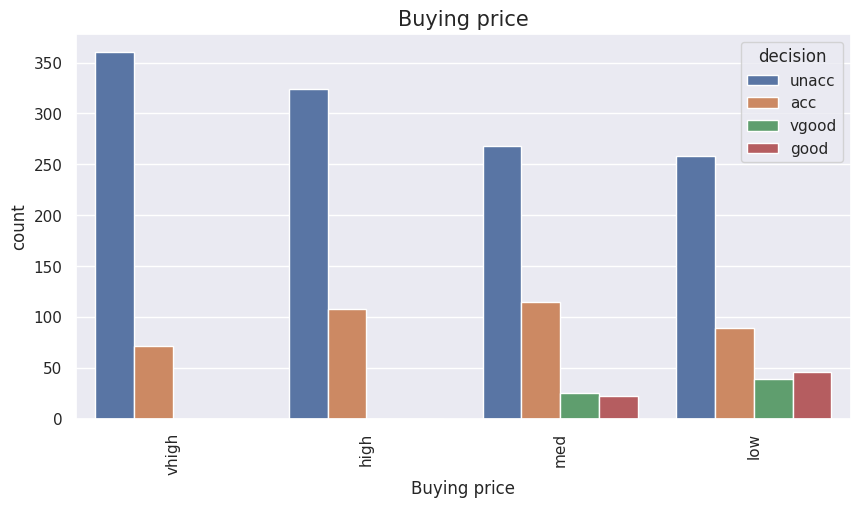

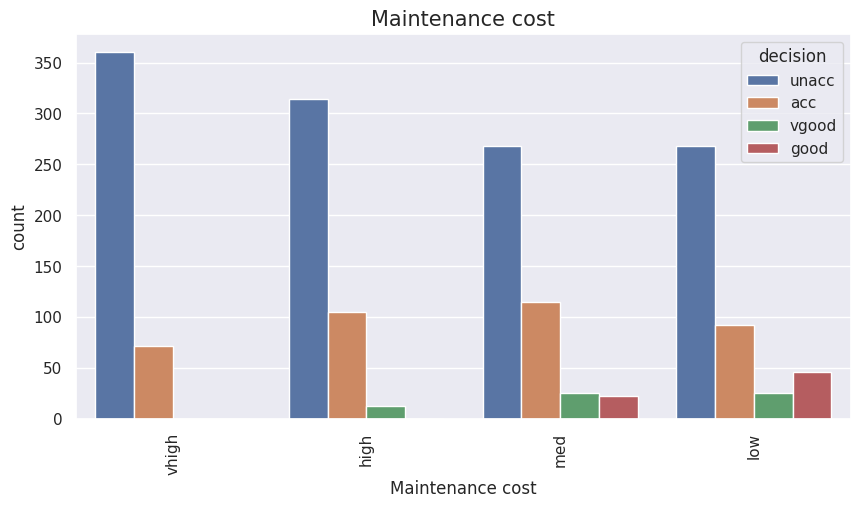

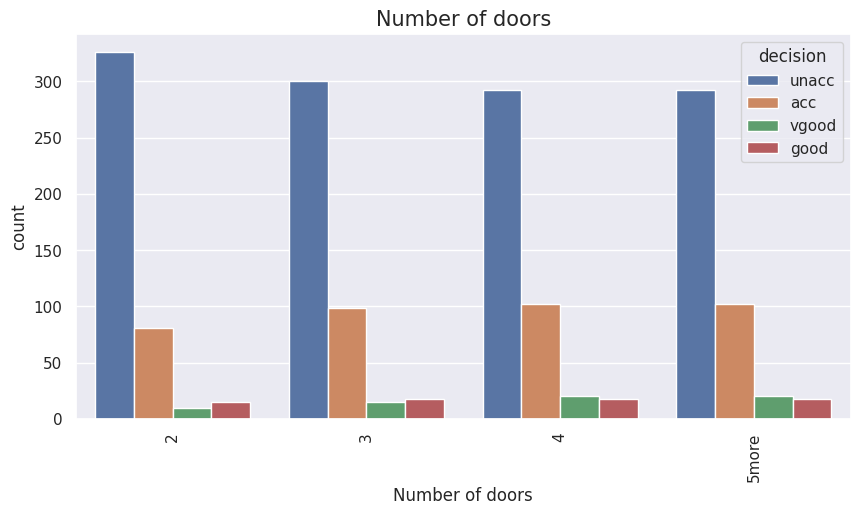

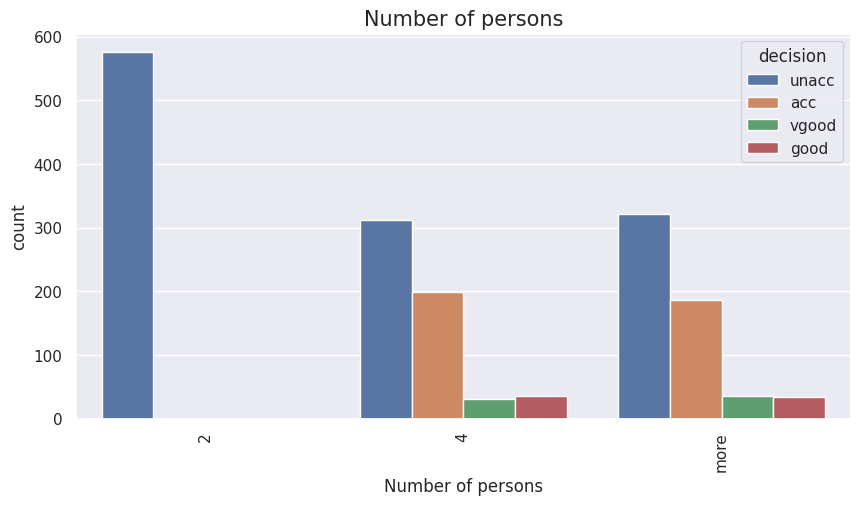

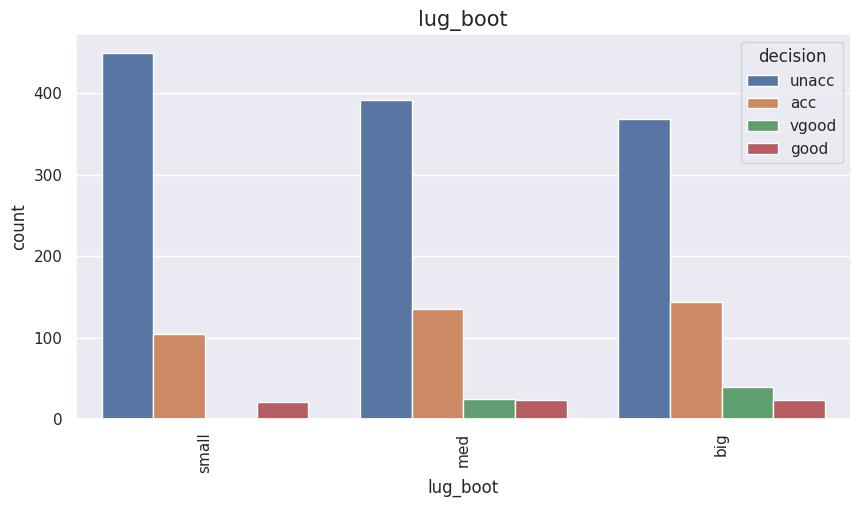

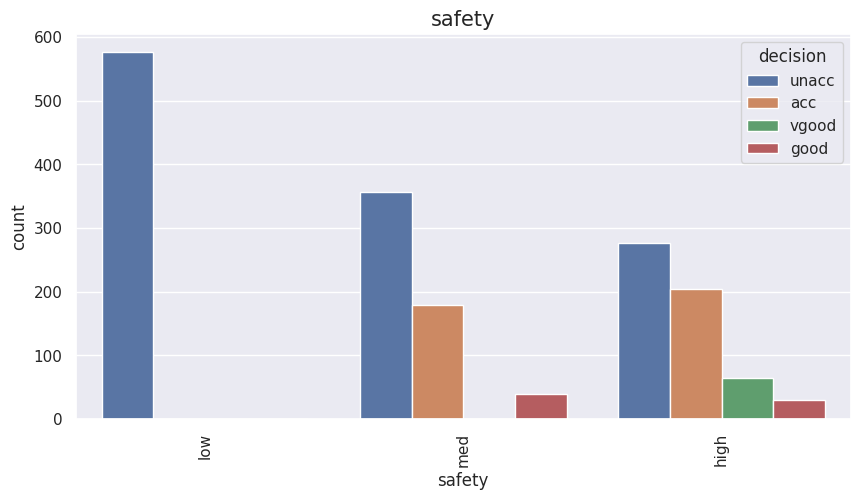

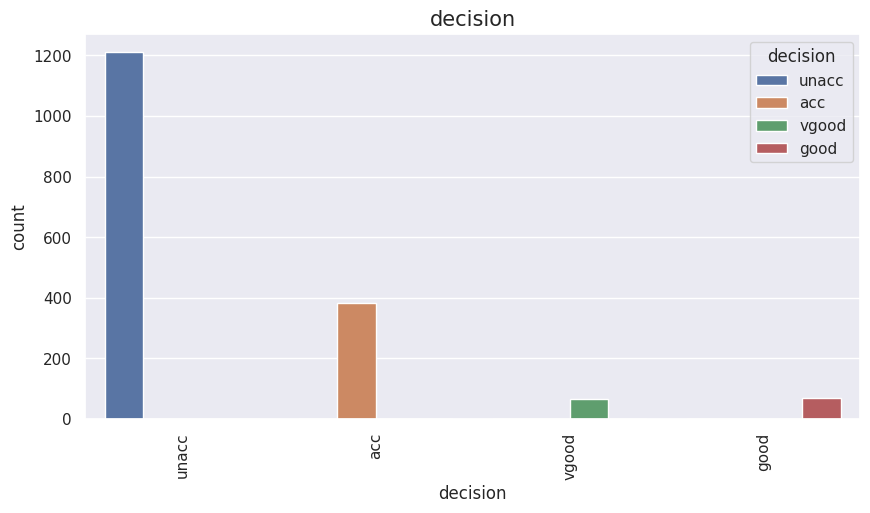

In [22]:
sns.set()
#check the bar plots for categorical features
for cat in df.columns:
  plt.figure(figsize=(10,5))
  sns.countplot(x=cat,data=df,hue='decision')
  plt.title(cat,fontsize=15)
  plt.xticks(rotation=90)
  plt.savefig(f"{cat}.png",bbox_inches = 'tight')
  plt.show()

##Cramer's V for correlation among categorical features

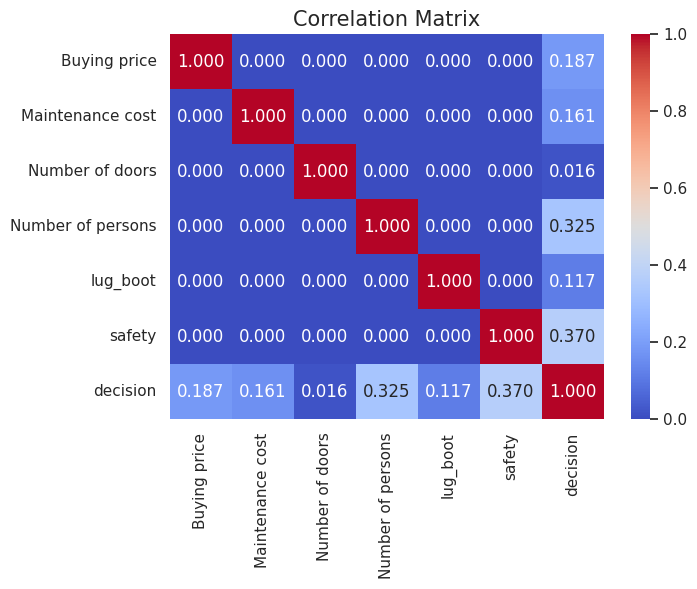

In [23]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate correlation matrix for all features (including numerical and categorical)
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=np.float64)

for feature1 in df.columns:
    for feature2 in df.columns:
        if df[feature1].dtype == 'object' and df[feature2].dtype == 'object':
            # Calculate Cramér's V for two categorical variables
            conf = pd.crosstab(df[feature1], df[feature2])
            correlation_matrix.loc[feature1, feature2] = cramers_v(conf.values)

# Visualize the correlation matrix using Seaborn heatmap
plt.figure(figsize=(7,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Matrix",fontsize=15)
plt.show()

**Independent features are almost uncorrelated. And the Decision feature is clearly dependent on the other features. So this data is really perfect to work. Without any necessity of feature selection**

In [24]:
#drop the target
y=df.pop('decision')
X=df

In [25]:
#splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

## Decision tree model class

In [26]:
#Define an utility class for decision tree
class DecisionTree:
  """
  Decision tree custom class
  """
  def _init_(tr):
    pass
  def label_enc(tr,A):
    """
    Encode the data
    Args : custom class object, input data
    """
    cp_A=copy.deepcopy(A)
    cp_A=cp_A.apply(LabelEncoder().fit_transform)
    return cp_A
  def fit(tr,A,b):
    """
    Fit the model
    Args : custom class object, input data, target
    """
    cp_A=copy.deepcopy(A)
    cp_A=tr.label_enc(cp_A)
    tr.clf=DecisionTreeClassifier(criterion='gini',max_depth=12)
    tr.clf.fit(cp_A,b)
    return tr.clf
  def predict(tr,A):
    """
    Predicts the data
    Args : custom class object, input data
    """
    D=tr.clf.predict(tr.label_enc(A))
    D_p=tr.clf.predict_proba(tr.label_enc(A))
    return D,D_p
  def score(tr,b1,b2):
    """
    Predicts the score
    Args : custom class object, true label, predicted label
    """
    sc=accuracy_score(b1,b2)
    return sc
  def plot(tr,A,b):
    """
    Gets the tree plot
    Args : custom class object, input data, predicted label
    """
    cp_A=tr.label_enc(A)
    dot_data=tree.export_graphviz(tr.clf,out_file=None,feature_names=np.unique(cp_A.columns),class_names=np.unique(b),filled=True,rounded=True,special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph
  def cm(tr,y1,y2):
    """
    Plot the confusion matrix
    Args : custom class object, true label, predicted label
    """
    labels=np.unique(y1)
    CM=confusion_matrix(y1,y2)
    plt.figure(figsize=(10,8))
    plt.title("Confusion Matrix",fontsize=22)
    sns.heatmap(CM,annot=True,cmap='Pastel2',fmt='0.3g',linewidths=1.0)
    plt.yticks(np.arange(len(labels))+0.5,labels,fontsize=14,rotation='horizontal')
    plt.xticks(np.arange(len(labels))+0.5,labels,fontsize=14)
    plt.xlabel("Predicted",fontsize=20)
    plt.ylabel("Actual",fontsize=20)
    plt.savefig("Conf.png")
    plt.show()

In [76]:
#call the class and fit the model
E=DecisionTree()
E.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=12)

In [77]:
yhat_train,yhat_train_p=E.predict(X_train)[0],E.predict(X_train)[1]

In [78]:
E.score(y_train.values,yhat_train)#Get the accuracy score for train set

0.9985528219971056

In [79]:
yhat_test,yhat_test_p=E.predict(X_test)[0],E.predict(X_train)[1]
E.score(y_test.values,yhat_test)#Get the accuracy for test set

0.9913294797687862

## Visualization of the tree

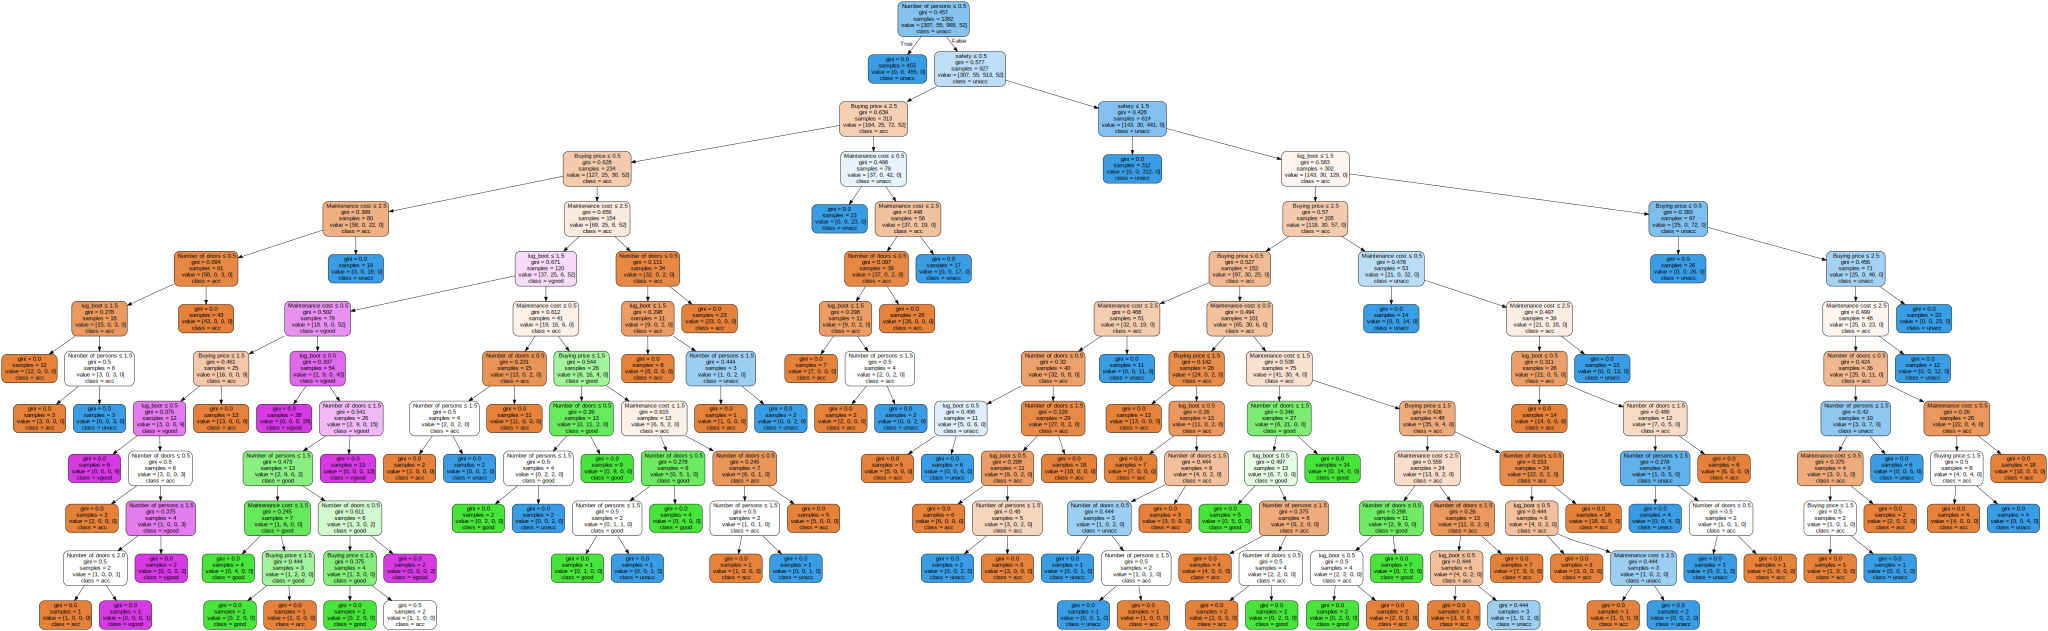

In [80]:
E.plot(X_train,y_train)

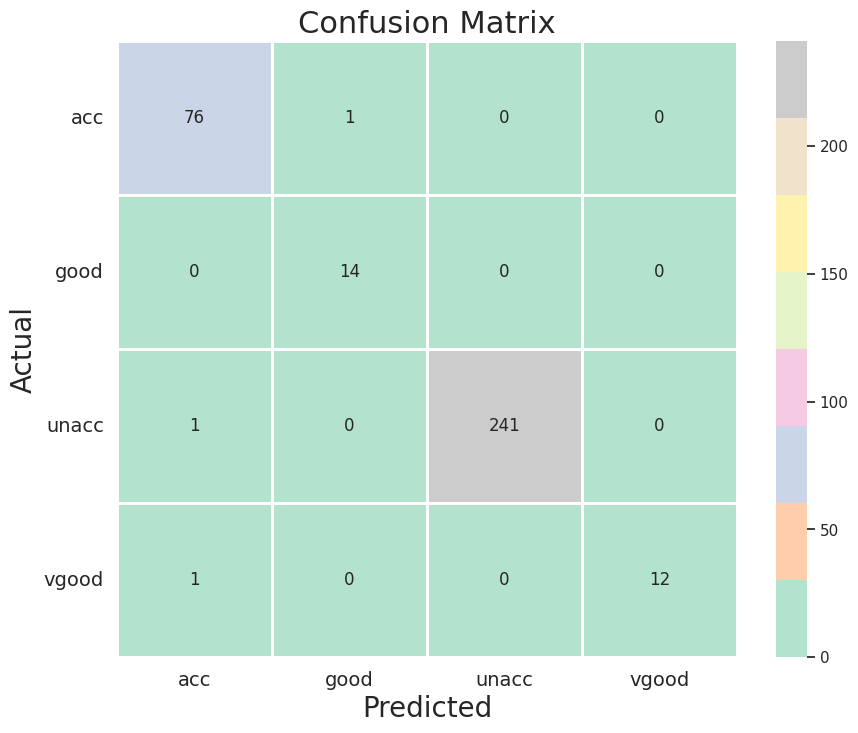

In [81]:
E.cm(y_test.values,yhat_test)#Check the confusion matrix

In [70]:
print(classification_report(y_test.values,yhat_test))#Classification metrics for the test set

              precision    recall  f1-score   support

         acc       0.97      0.99      0.98        77
        good       0.93      1.00      0.97        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      0.92      0.96        13

    accuracy                           0.99       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346



## Get the one hot encoded data for ROC curve

In [54]:
oh_test=pd.get_dummies(y_test)

In [55]:
oh_pred=pd.get_dummies(pd.Series(yhat_test))

## ROC curve

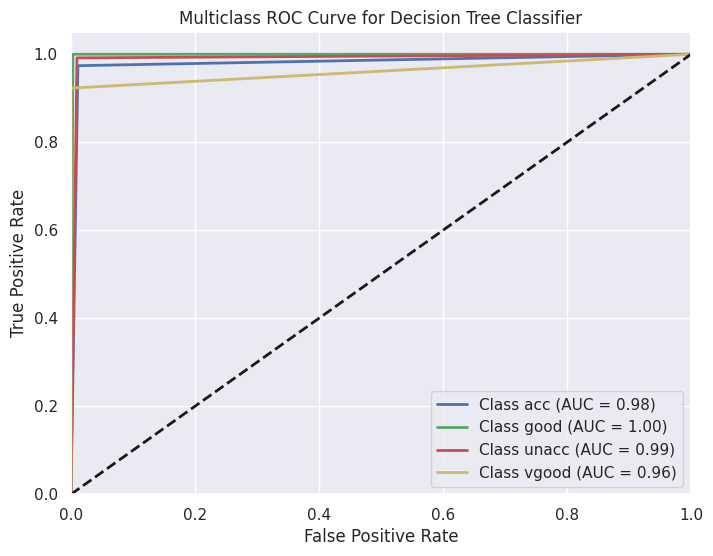

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=oh_test.columns
for i in num_classes:
    fpr[i], tpr[i], _ = roc_curve(oh_test.loc[:, i], oh_pred.loc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r','y']  # Use appropriate colors based on the number of classes
for i, color in zip(num_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.savefig("ROC.png")
plt.show()

## Comparison of the plot in test data for labels between ground truth labels and predicted labels

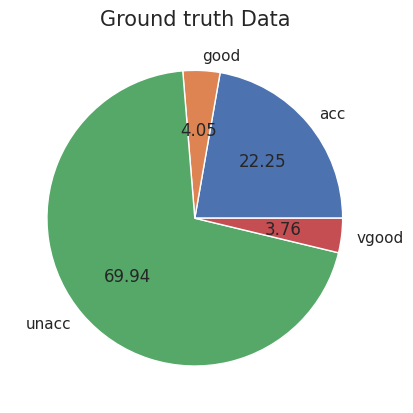

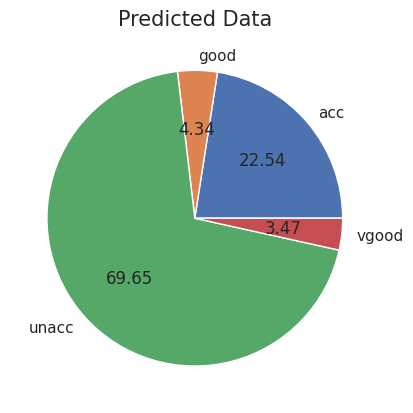

In [57]:
Y_test=pd.DataFrame(y_test)
Y_pred=pd.DataFrame(yhat_test,columns=['decision'])
Y_test.groupby('decision').size().plot(kind='pie',autopct='%.2f')
plt.title("Ground truth Data",fontsize=15)
plt.show()
Y_pred.groupby('decision').size().plot(kind='pie', autopct='%.2f')
plt.title("Predicted Data",fontsize=15)
plt.show()

In [58]:
X_test1=copy.deepcopy(X_test)
X_test2=copy.deepcopy(X_test)
X_test1['decision']=y_test
X_test2['decision_predicted']=yhat_test

## Verification of the test data

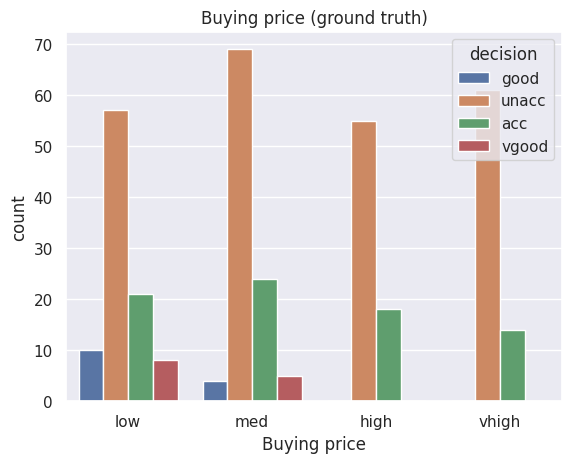

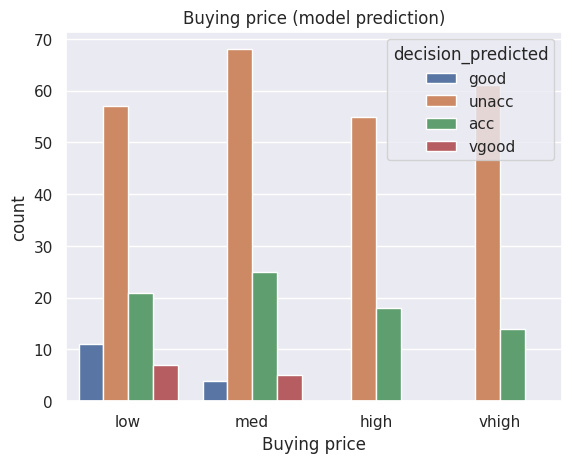

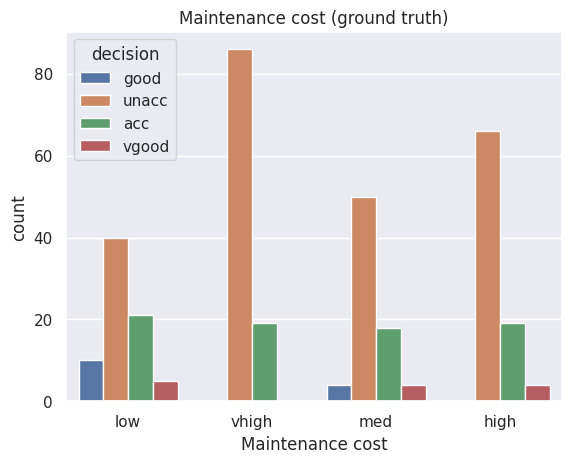

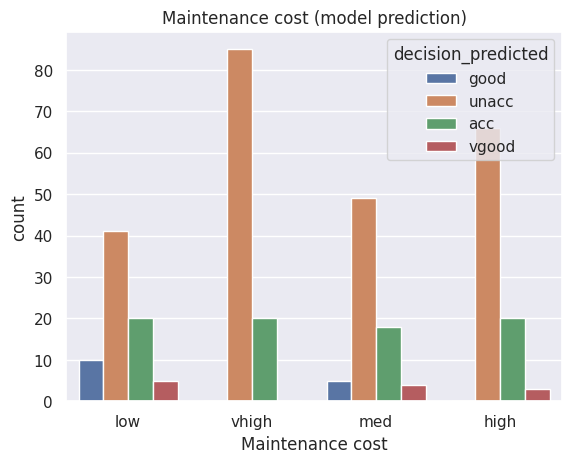

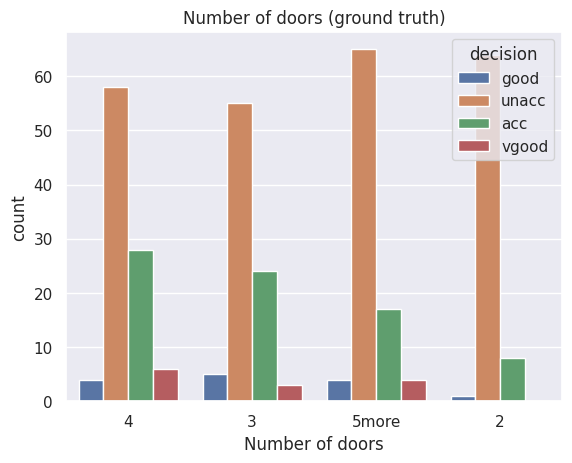

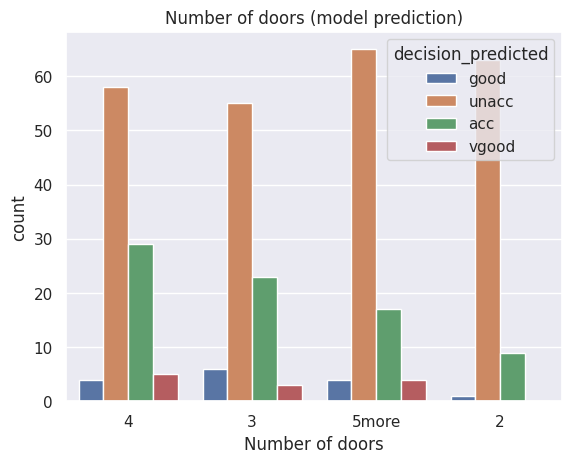

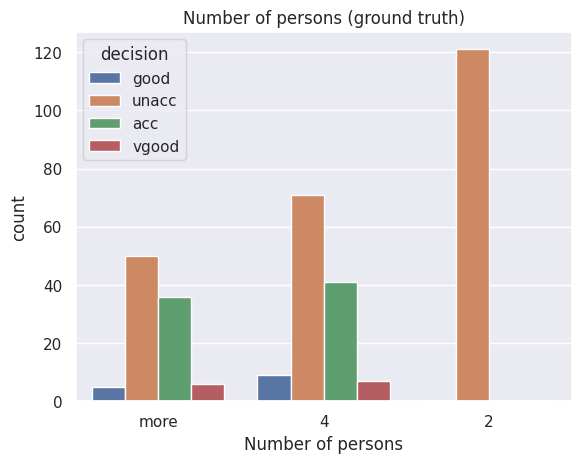

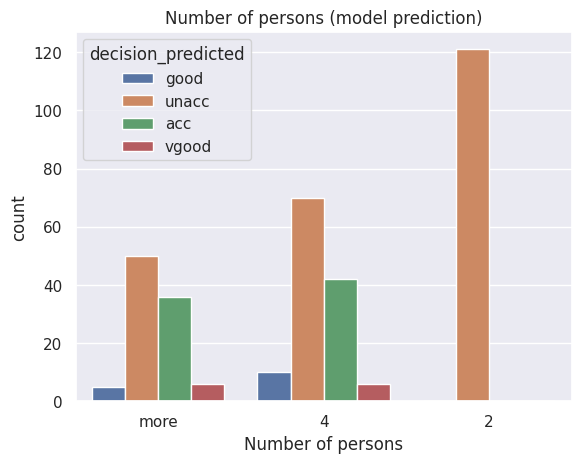

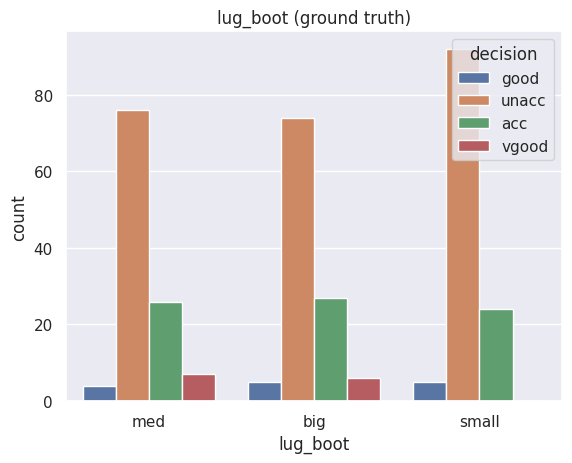

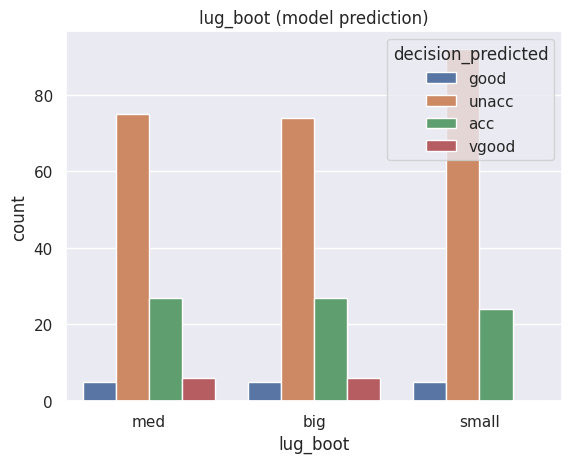

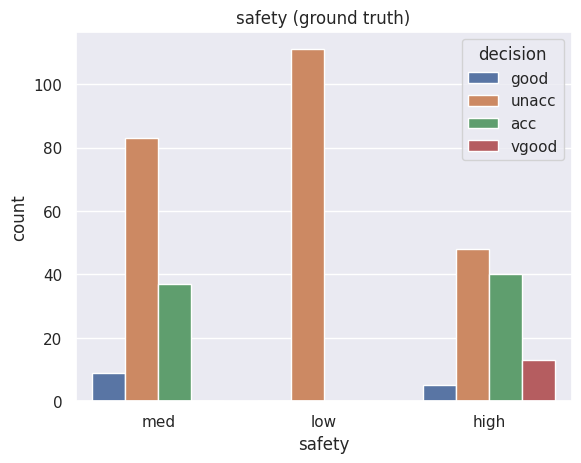

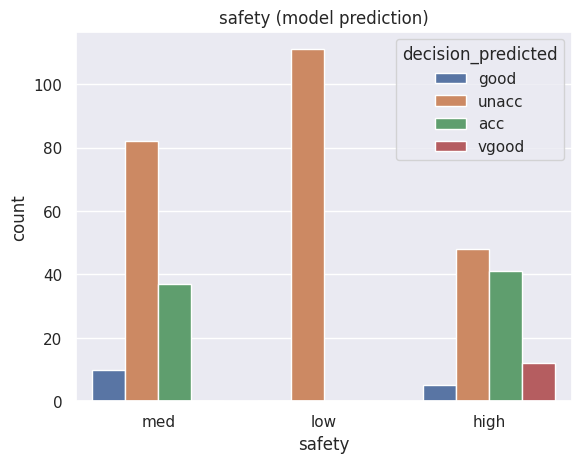

In [59]:
cols=['Buying price','Maintenance cost','Number of doors','Number of persons','lug_boot','safety']
for cat in cols:
  #fig, ax = plt.subplots(2,1 , figsize=(9, 10))
  #fig.suptitle(cat,fontsize=20)
  plt.title(f"{cat} (ground truth)")
  sns.countplot(x=cat,data=X_test1,hue='decision')
  plt.savefig(f"test_{cat}_tru.png",bbox_inches = 'tight')
  plt.show()
  plt.title(f"{cat} (model prediction)")
  sns.countplot(x=cat,data=X_test2,hue='decision_predicted')
  #ax[0].set_title("Ground truth case",fontsize=15)
  #ax[1].set_title("Predicted case",fontsize=15)
  #ax[0].set_xticklabels(labels=X_test1[cat].unique(),rotation=90)
  #ax[1].set_xticklabels(labels=X_test1[cat].unique(),rotation=90)
  plt.savefig(f"test_{cat}_pred.png",bbox_inches = 'tight')
  plt.show()

#End of Code